# Exercise 3.2
Welcome to the last exercise of this course. This is also the most advanced one because it somehow glues everything together you've learned. 

These are the steps you will do:
- load a data frame from cloudant/ApacheCouchDB
- perform feature transformation by calculating minimal and maximal values of different properties on time windows (we'll explain what a time windows is later in here)
- reduce these now twelve dimensions to three using the PCA (Principal Component Analysis) algorithm of SparkML (Spark Machine Learning) => We'll actually make use of SparkML a lot more in the next course
- plot the dimensionality reduced data set

### TODO Please provide your Cloudant credentials here

In [1]:
hostname = "dc5a4654-cfd1-4ed6-92a9-ce5c62c07a9e-bluemix.cloudant.com"
user = "dc5a4654-cfd1-4ed6-92a9-ce5c62c07a9e-bluemix"
pw = "e26a7317318ce637fa77c9bdbe3a6df3522857b38eed9e78d29c4790fac05dd3"
database = "washing"

In [2]:
spark = SparkSession\
    .builder\
    .appName("Cloudant Spark SQL Example in Python using temp tables")\
    .config("cloudant.host",hostname)\
    .config("cloudant.username", user)\
    .config("cloudant.password",pw)\
    .getOrCreate()


In [3]:
#Please don't modify this function
def readDataFrameFromCloudant(database):
    cloudantdata=spark.read.load(database, "org.apache.bahir.cloudant")

    cloudantdata.createOrReplaceTempView("washing")
    spark.sql("SELECT * from washing").show()
    return cloudantdata

In [4]:
cloudantdata=readDataFrameFromCloudant(database)
cloudantdata.createOrReplaceTempView("washing")
spark.sql("SELECT * FROM washing").show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0e8d312b7b2c3bbff...|1-ed094e4c3eb51c4...|    1|      11|acceptable|     null|      71| null|        100|1537782394150|   null|
|0e8d312b7b2c3bbff...|1-779af9d7f2432d7...|    5|      11|acceptable|     null|      74| null|         93|1537782398163|   null|
|0e8d312b7b2c3bbff...|1-63ac08956b65882...|    2|    null|      null|     null|    null| 1082|       null|1537782403163|   null|
|0e8d312b7b2c3bbff...|1-c34509e3a029005...|   14|      11|acceptable|     null|      75| null|         96|1537782407194|   null|
|0e8d312b7b2c3bbff...|1-fdfa152bb423194...|    6|    null|      null|       63|    null| null|   

This is the feature transformation part of this exercise. Since our table is mixing schemas from different sensor data sources we are creating new features. In other word we use existing columns to calculate new ones. We only use min and max for now, but using more advanced aggregations as we've learned in week three may improve the results. We are calculating those aggregations over a sliding window "w". This window is defined in the SQL statement and basically reads the table by a one by one stride in direction of increasing timestamp. Whenever a row leaves the window a new one is included. Therefore this window is called sliding window (in contrast to tubling, time or count windows). More on this can be found here: https://flink.apache.org/news/2015/12/04/Introducing-windows.html



In [5]:
result = spark.sql("""
SELECT * from (
    SELECT
    min(temperature) over w as min_temperature,
    max(temperature) over w as max_temperature, 
    min(voltage) over w as min_voltage,
    max(voltage) over w as max_voltage,
    min(flowrate) over w as min_flowrate,
    max(flowrate) over w as max_flowrate,
    min(frequency) over w as min_frequency,
    max(frequency) over w as max_frequency,
    min(hardness) over w as min_hardness,
    max(hardness) over w as max_hardness,
    min(speed) over w as min_speed,
    max(speed) over w as max_speed
    FROM washing 
    WINDOW w AS (ORDER BY ts ROWS BETWEEN CURRENT ROW AND 10 FOLLOWING) 
)
WHERE min_temperature is not null 
AND max_temperature is not null
AND min_voltage is not null
AND max_voltage is not null
AND min_flowrate is not null
AND max_flowrate is not null
AND min_frequency is not null
AND max_frequency is not null
AND min_hardness is not null
AND min_speed is not null
AND max_speed is not null   
""")

Since this table contains null values also our window might contain them. In case for a certain feature all values in that window are null we obtain also null. As we can see here (in my dataset) this is the case for 9 rows.

In [7]:
cloudantdata.count()-result.count()

4

Now we import some classes from SparkML. PCA for the actual algorithm. Vectors for the data structure expected by PCA and VectorAssembler to transform data into these vector structures.

In [8]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

Let's define a vector transformation helper class which takes all our input features (result.columns) and created one additional column called "features" which contains all our input features as one single column wrapped in "DenseVector" objects

In [9]:
assembler = VectorAssembler(inputCols=result.columns, outputCol="features")

Now we actually transform the data, note that this is highly optimized code and runs really fast in contrast if we had implemented it.

In [10]:
features = assembler.transform(result)

Let's have a look at how this new additional column "features" looks like:

In [11]:
features.rdd.map(lambda r : r.features).take(10)

[DenseVector([83.0, 100.0, 226.0, 230.0, 11.0, 11.0, 73.0, 75.0, 70.0, 79.0, 1034.0, 1034.0]),
 DenseVector([83.0, 99.0, 226.0, 230.0, 11.0, 11.0, 73.0, 78.0, 70.0, 79.0, 1034.0, 1034.0]),
 DenseVector([81.0, 99.0, 226.0, 230.0, 11.0, 11.0, 73.0, 78.0, 70.0, 79.0, 1034.0, 1034.0]),
 DenseVector([81.0, 99.0, 226.0, 229.0, 11.0, 11.0, 75.0, 78.0, 70.0, 79.0, 1034.0, 1082.0]),
 DenseVector([81.0, 99.0, 226.0, 229.0, 11.0, 11.0, 75.0, 78.0, 73.0, 79.0, 1034.0, 1082.0]),
 DenseVector([81.0, 96.0, 226.0, 229.0, 11.0, 11.0, 75.0, 78.0, 73.0, 79.0, 1034.0, 1082.0]),
 DenseVector([81.0, 96.0, 226.0, 236.0, 11.0, 11.0, 65.0, 78.0, 73.0, 79.0, 1082.0, 1082.0]),
 DenseVector([81.0, 96.0, 226.0, 236.0, 11.0, 11.0, 65.0, 78.0, 73.0, 79.0, 1082.0, 1082.0]),
 DenseVector([81.0, 96.0, 229.0, 236.0, 11.0, 11.0, 65.0, 78.0, 73.0, 79.0, 1082.0, 1082.0]),
 DenseVector([81.0, 96.0, 229.0, 236.0, 11.0, 11.0, 65.0, 78.0, 73.0, 79.0, 1082.0, 1082.0])]

Since the source data set has been prepared as a list of DenseVectors we can now apply PCA. Note that the first line again only prepares the algorithm by finding the transformation matrices (fit method)

In [12]:
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(features)

Now we can actually transform the data. Let's have a look at the first 20 rows

In [13]:
result_pca = model.transform(features).select("pcaFeatures")
result_pca.show(truncate=False)

+----------------------------------------------------------+
|pcaFeatures                                               |
+----------------------------------------------------------+
|[1475.1431736042546,-71.77088407831278,-73.25744209626203]|
|[1475.1837365118422,-71.74258812179346,-73.15738641914538]|
|[1475.1869654575708,-71.70224171775638,-73.15080714770545]|
|[1510.5196866142485,-73.96993910038881,-40.89796137301789]|
|[1510.599114930285,-72.67091034215261,-41.116594810053016]|
|[1510.612558242069,-72.647487206118,-41.066893161709345]  |
|[1542.742173317481,-78.11227081654587,-76.96578439643417] |
|[1542.742173317481,-78.11227081654587,-76.96578439643417] |
|[1542.852571971478,-78.05859515547874,-76.91339126161063] |
|[1542.852571971478,-78.05859515547874,-76.91339126161063] |
|[1542.6685742148165,-78.14805459059062,-77.00071315298328]|
|[1537.36026845996,-77.16558110885069,-71.11328863681854]  |
|[1537.2520230489818,-77.22704584237403,-71.36375401982502]|
|[1537.2504085761175,-77

So we obtained three completely new columns which we can plot now. Let run a final check if the number of rows is the same.

In [14]:
result_pca.count()

334

Cool, this works as expected. Now we obtain a sample and read each of the three columns into a python list

In [15]:
rdd = result_pca.rdd.sample(False,0.1)

In [16]:
x = result_pca.rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[0]).collect()

In [17]:
y = result_pca.rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[1]).collect()

In [18]:
z = result_pca.rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[2]).collect()

Finally we plot the three lists and name each of them as dimension 1-3 in the plot

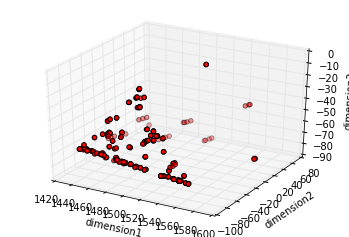

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')




ax.scatter(x,y,z, c='r', marker='o')

ax.set_xlabel('dimension1')
ax.set_ylabel('dimension2')
ax.set_zlabel('dimension3')

plt.show()

Congratulations, we are done! We can see two clusters in the data set. We can also see a third cluster which either can be outliers or a real cluster. In the next course we will actually learn how to compute clusters automatically. For now we know that the data indicates that there are two semi-stable states of the machine and sometime we see some anomalies since those data points don't fit into one of the two clusters.